# GST on Rigetti Backends with PyGSTi
The purpose of this notebook is to use the data collected from a GST experiment that has been read into the `rigetti_first_run` directory and perform GST on it, then use Mitiq's algorithm to produce a QPD representation of the resultant noisy gates for use in PER.

The original code for the GST analysis in PyGSTi can be found here:[UnitaryFundDemoNotebook1.ipynb
](https://zenodo.org/record/5715199#.Yr_TOUjMLJF). 

In [40]:
#PyGSTi tools
import pygsti
from pygsti.modelpacks import smq1Q_XZ
from pygsti.data.dataset import DataSet

#Mitiq tools
from mitiq.pec import NoisyOperation, NoisyBasis, OperationRepresentation, execute_with_pec
from mitiq.pec.representations.optimal import find_optimal_representation

#Qiskit imports
from qiskit import QuantumCircuit
from qiskit.quantum_info import SuperOp, PTM 
from qiskit.circuit.library import RZGate, SXGate  
from qiskit import transpile
from qiskit.providers.aer.noise import NoiseModel, QuantumError
from qiskit import execute, Aer

#Helper libraries
import numpy as np
from itertools import product
import matplotlib.pyplot as plt

#make numpy matrices easier to read
np.set_printoptions(precision=6, suppress=True)
plt.style.use("ggplot")

## Read data from experiment
This data was written by the `get_gst_data.ipynb` file.

In [2]:
data = pygsti.io.read_data_from_dir('experiment_data/rigetti_first_run')

## Run GST on the data

In [13]:
gst_protocol = pygsti.protocols.StandardGST('TP,CPTP,Target')
results = gst_protocol.run(data)

-- Std Practice:  Iter 1 of 3  (TP) --: 
  --- Iterative GST: [##################################################] 100.0%  550 circuits ---
  Iterative GST Total Time: 1.5s
-- Std Practice:  Iter 2 of 3  (CPTP) --: 
  --- Iterative GST: [##################################################] 100.0%  550 circuits ---
  Iterative GST Total Time: 11.4s
-- Std Practice:  Iter 3 of 3  (Target) --: 


## Constrain to TPCP and gauge-optimize
The estimates_final_model is an `ExplicitOpModel` type, which carries the preps, measurements, and operations as Pauli-transfer matrices. The documentation refers to this as the 'pauli-product' basis. The `qiskit.quantum_info` tools can be used to convert these into superoperators, which is the form mitiq uses to describe quantum channels.

## Re-run GST experiment with fixed Rz

In this subsection we impose that RZ  must be equal to the ideal operation. On most superconducting platforms, the Rz gate is virtualized, so it incurs no extra noise or execution time. This is convenient for PEC, because choosing a guage in which the Rz gate is noiseless allows arbitrary Z-rotations to be performed, since the ideal gate has a QPD representation containing only itself.

This is procedure is adapted from page 3 of https://arxiv.org/abs/2002.12476.
The main difference is that, instead of starting from a default initial model, we take the model the we obtained in the previous section, we fix RZ, and we use it as the initial condition for a new GST estimation.

(Literally applying procedure of page 3 of https://arxiv.org/abs/2002.12476 produce a final result but doesn't seem to make sense since all operators look like ideal gates).

In [14]:
# Define ideal RZ operation
target_mdl = smq1Q_XZ.target_model()
rz_matrix = target_mdl[('Gzpi2',0)].to_dense()
dense_rz = pygsti.modelmembers.operations.DenseOperator(rz_matrix, evotype="default")

In [15]:
cptp_estimate = results.estimates['CPTP']
initial_model = cptp_estimate.models['stdgaugeopt']
initial_model[('Gzpi2',0)] = dense_rz

In [16]:
# Run GST (on existing data)
results = pygsti.protocols.GST(initial_model, gaugeopt_suite=None).run(data)

--- Iterative GST: Iter 1 of 6  52 circuits ---: 
  MatrixLayout: 1 processors divided into 1 x 1 (= 1) grid along circuit and parameter directions.
     1 atoms, parameter block size limits (None,)
  *** Distributing 1 atoms to 1 atom-processing groups (1 cores) ***
      More atom-processors than hosts: each host gets ~1 atom-processors
      Atom-processors already occupy a single node, dividing atom-processor into 1 param-processors.
  *** Divided 1-host atom-processor (~1 procs) into 1 param-processing groups ***
  --- chi2 GST ---
  Sum of Chi^2 = 106.368 (52 data params - 36 (approx) model params = expected mean of 16; p-value = 2.22045e-15)
  Completed in 1.3s
  Iteration 1 took 1.3s
  
--- Iterative GST: Iter 2 of 6  96 circuits ---: 
  MatrixLayout: 1 processors divided into 1 x 1 (= 1) grid along circuit and parameter directions.
     1 atoms, parameter block size limits (None,)
  *** Distributing 1 atoms to 1 atom-processing groups (1 cores) ***
      More atom-processors t

In [17]:
new_model = results.estimates['GateSetTomography'].models['final iteration estimate']

In [18]:
# Convert operator transfer matrix to superoperator
superop_rep_x = SuperOp(PTM(new_model.operations[('Gxpi2',0)].to_dense()))
superop_rep_z = SuperOp(PTM(new_model.operations[('Gzpi2',0)].to_dense()))
superops = [superop_rep_x, superop_rep_z]

In [21]:
print(superop_rep_x)
print(superop_rep_z)

SuperOp([[ 0.505+0.j   , -0.029-0.487j, -0.029+0.487j,  0.489+0.j   ],
         [-0.03 -0.49j ,  0.5  -0.059j,  0.489+0.001j,  0.036+0.486j],
         [-0.03 +0.49j ,  0.489-0.001j,  0.5  +0.059j,  0.036-0.486j],
         [ 0.495+0.j   ,  0.029+0.487j,  0.029-0.487j,  0.511+0.j   ]],
        input_dims=(2,), output_dims=(2,))
SuperOp([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+1.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 0.-1.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]],
        input_dims=(2,), output_dims=(2,))


In [19]:
superop_rep_x.is_cptp()

True

## Creating a QPD Representation
In this section, we go through a process for creating a QPD representation of an ideal `SX` gate in terms of noisy implementable operations as a Mitiq `OperationRepresentation` object for use in PER.

In [23]:
#Create a list of ideal gates as labels for the noisy ones
ideal_gates = [SXGate(), RZGate(np.pi/2)]

### Create a noisy basis
In order to create a NoisyBasis, we iterate through the possible sequences of noisy gates up to a certain length.

In [24]:
def get_gate_sequences(n):
    NoisyOperations = []

    for string in product(zip(superops,ideal_gates), repeat=n): #combine the noisy and ideal ops and iterate through words
        qc = QuantumCircuit(1)
        superop = SuperOp(np.identity(4)) #start at the identity op

        for (noisy_op, ideal_op) in string: #iterate through all the pairs in string
            qc.append(ideal_op,[0]) #add the ideal op to circuit
            superop = superop.compose(noisy_op) #compose the noisy op for total channel

        NoisyOperations.append(NoisyOperation(qc, superop.data)) #Instatiate NoisyOperation and add to array
    
    return NoisyOperations.copy()

NoisyOperations = []
N = 4

for i in range(N): #do this for all n <= N
    NoisyOperations = np.concatenate((NoisyOperations, get_gate_sequences(i+1)))

#combine into basis object
noisy_basis = NoisyBasis(*NoisyOperations)

In [33]:
optimal_circuit = QuantumCircuit(1)
optimal_circuit.rx(-np.pi/2, 0) #Mitiq uses the opposite sign convention for the rotation gates, 
#so the correct value needs to be patched in afterward

#Use the Mitiq find_optimal_representation algorithms to get the QPD representation of an ideal
#gate in terms of noisy gates
optimal_rep = find_optimal_representation(optimal_circuit, noisy_basis, tol=.0001)

#Correct the sign of the rotation and create an OperationRepresentation for this gate
optimal_circuit = QuantumCircuit(1)
optimal_circuit.sx(0)
optimal_rep = OperationRepresentation(optimal_circuit,optimal_rep.basis_expansion)

print(optimal_rep)
print("Overhead: ", optimal_rep.norm) #hopefully close to 1

q_0: ───X^0.5─── = 0.277*(q_0: ───Rz(0.5π)───X^0.5───X^0.5───Rz(0.5π)───)-0.112*(q_0: ───X^0.5───X^0.5───X^0.5───X^0.5───)-0.372*(q_0: ───Rz(0.5π)───X^0.5───Rz(0.5π)───Rz(0.5π)───)-0.008*(q_0: ───Rz(0.5π)───Rz(0.5π)───Rz(0.5π)───X^0.5───)+0.048*(q_0: ───Rz(0.5π)───)+0.010*(q_0: ───X^0.5───Rz(0.5π)───Rz(0.5π)───Rz(0.5π)───)+0.005*(q_0: ───Rz(0.5π)───X^0.5───X^0.5───)-0.314*(q_0: ───X^0.5───X^0.5───X^0.5───)+0.717*(q_0: ───X^0.5───)+0.389*(q_0: ───X^0.5───X^0.5───Rz(0.5π)───X^0.5───)+0.024*(q_0: ───Rz(0.5π)───X^0.5───Rz(0.5π)───X^0.5───)-0.030*(q_0: ───Rz(0.5π)───Rz(0.5π)───X^0.5───)+0.364*(q_0: ───Rz(0.5π)───Rz(0.5π)───Rz(0.5π)───Rz(0.5π)───)
Overhead:  2.670075902263854


### Testing the QPD representation
In order to check if the correct superoperator is reproduced, we can compute the value of the above sum explicitly and compare it to the ideal gate:

In [30]:
matrices = [m.channel_matrix for m in optimal_rep.noisy_operations]
mat = sum(m*coeff for (m,coeff) in zip(matrices, optimal_rep.coeffs))
print("Approximated superoperator")
print(mat)
print('------------------------------')
print("Ideal superoperator")
ideal_mat = SuperOp(SXGate()).data #It clearly matches RX(pi/2), but I don't know why
print(ideal_mat)

Approximated superoperator
[[ 0.5-0.j   0. -0.5j  0. +0.5j  0.5+0.j ]
 [ 0. -0.5j  0.5-0.j   0.5+0.j   0. +0.5j]
 [ 0. +0.5j  0.5-0.j   0.5+0.j   0. -0.5j]
 [ 0.5+0.j  -0. +0.5j -0. -0.5j  0.5-0.j ]]
------------------------------
Ideal superoperator
[[0.5+0.j  0. -0.5j 0. +0.5j 0.5+0.j ]
 [0. -0.5j 0.5+0.j  0.5+0.j  0. +0.5j]
 [0. +0.5j 0.5+0.j  0.5+0.j  0. -0.5j]
 [0.5+0.j  0. +0.5j 0. -0.5j 0.5+0.j ]]


## Apply PER
In order to apply PER, we define a method which accepts as input an OperationRepresentation and returns another OperationRepresentation that has been scaled according to [canonical noise scaling](https://arxiv.org/abs/2108.02237). The representation can be defined as the following: 

## Canonical Noise Scaling

Canonical noise scaling involves separating the distribution into the negative and positive volumes by the sign of the coefficients. Given a QPD representation of a unitary $\mathcal{U}$ in terms of noisy gates $\mathcal{O}_\alpha\in \mathcal{I}$,
$$
\mathcal{U} = \sum_{\alpha} \eta_\alpha \mathcal{O}_\alpha
$$
the indices $\alpha$ corresponding to negative and positive coefficients can be separated into two sets:
$$
D^{\pm} = \{\alpha \ | \ \eta_\alpha \gtrless 0\}
$$
Then the gates corresponding to each set can be used to construct a TPCP operator:
$$
\Phi^{\pm} = \frac{1}{\gamma^{\pm}}\sum_{\alpha \in D^{\pm}}|\eta_\alpha| \mathcal{O}_\alpha
$$
Where the overhead is selected so that the operator is trace-preserving:
$$
\gamma^{\pm} = \sum_{\alpha \in D^{\pm}}|\eta_\alpha|
$$
Then $\mathcal{U}$ can be written in terms of these channels:
$$
\mathcal{U} = \gamma^+ \Phi^+ - \gamma^- \Phi^-
$$
A noisy gate $\mathcal{U}^\lambda$ can be parameterized as
$$
\mathcal{U}^\lambda = (\gamma^+-\lambda \gamma^-)\Phi^+-(1-\lambda)\gamma^-\Phi^-
$$
This has the convenient property that at $\lambda = 0$ it reduces to the ideal QPD, at $\lambda = 1$ it reduces to $\Phi^+$ representing around hardware noise level, and at $\lambda = \frac{\gamma^+}{\gamma^-}$ it reduces to $\Phi^-$, representing the greatest level of noise.

Lastly, the overheads $\gamma^+$ and $\gamma^-$ can be computed in terms of $\gamma$, using the equations
$$
\gamma^+-\gamma^- = 1\\
\gamma^+ + \gamma^- = \gamma
$$
Which hold when $\lambda < 1$. Adding and subtracting these yields
$$
\gamma^+ = \frac{\gamma+1}{2}\\
\gamma^- = \frac{\gamma-1}{2}
$$

In [37]:
#convert PEC rep to PER rep
def get_canonical_noise_scaled_rep(op_rep : OperationRepresentation,
                                   lmbda) -> OperationRepresentation:
    #copy data from previous rep
    noisy_ops = op_rep.noisy_operations
    coeffs = list(op_rep.coeffs)
    ideal_program = op_rep.ideal

    #define terms
    gammaminus = .5*(op_rep.norm-1)
    gammaplus = .5*(op_rep.norm+1)

    #scale coefficients accordingly
    for (i,coeff) in enumerate(coeffs):
        if coeff < 0:
            coeffs[i] = coeff*(1-lmbda)
        else:
            coeffs[i] = coeff/gammaplus*(gammaplus-lmbda*gammaminus)
    
    #construct and return new representation
    scaled_rep_dict = dict(zip(noisy_ops, coeffs))
    return OperationRepresentation(ideal_program, scaled_rep_dict)

In [59]:
lmbdas = [0,.2,.5,1]
superops_per = []
for lmbda in lmbdas:
    op_rep  = get_canonical_noise_scaled_rep(optimal_rep, lmbda)
    matrices = [m.channel_matrix for m in op_rep.noisy_operations]
    mat = sum(m*coeff for (m,coeff) in zip(matrices, op_rep.coeffs))
    superops_per.append(mat)
    print(np.linalg.norm(mat-SuperOp(SXGate()).data))

0.0005289151265869001
0.21548142091782624
0.5383517292371217
1.0764693273160775


In [61]:
superops_per[0]

array([[ 0.4999  -0.j    ,  0.0001  -0.4999j,  0.0001  +0.4999j,
         0.4999  +0.j    ],
       [ 0.0001  -0.5001j,  0.4999  -0.0001j,  0.499901+0.0001j,
         0.0001  +0.4999j],
       [ 0.0001  +0.5001j,  0.499901-0.0001j,  0.4999  +0.0001j,
         0.0001  -0.4999j],
       [ 0.5001  +0.j    , -0.0001  +0.4999j, -0.0001  -0.4999j,
         0.5001  -0.j    ]])

In [62]:
superops_per[3]

array([[ 0.525766-0.j      ,  0.091944-0.189491j,  0.091944+0.189491j,
         0.471613+0.j      ],
       [ 0.00261 -0.101892j,  0.390019-0.092393j,  0.352336+0.100312j,
         0.001549+0.103534j],
       [ 0.00261 +0.101892j,  0.352336-0.100312j,  0.390019+0.092393j,
         0.001549-0.103534j],
       [ 0.474234+0.j      , -0.091944+0.189491j, -0.091944-0.189491j,
         0.528387-0.j      ]])

## Visualizing overhead scaling
Overhead scaling is exponential in the circuit depth. This means that PEC and PER are ultimately unscalable. However, for practical purposes, PER can offer an advantage by incorporating information from noise levels with no overhead or a drastically reduced overhead. The following graph shows how the overhead scales with more layers for different noise strength values.

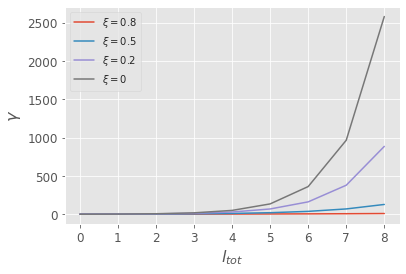

In [66]:
ax = np.arange(9)
plt.figure(figsize=(6,4))
gamma = optimal_rep.norm
lmbdas = [.8,.5,.2,0]
for lmbda in lmbdas:
    plt.plot(ax, [(gamma-lmbda*(gamma-1))**n for n in ax])

plt.xlabel(r"$l_{tot}$", fontsize = 16)
plt.ylabel(r"$\gamma$", fontsize = 16)
plt.tick_params(axis= "both", labelsize = 12)
plt.legend([r"$\xi = $" + str(lmbda) for lmbda in lmbdas])